In [25]:
import torch
import torch.nn as nn
from torchsummary import summary
import numpy as np
import scipy.io
from typing import List, Dict
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from prettytable import PrettyTable
import copy

In [26]:
gpu_id = 3
device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:3


In [27]:
# ------------------------- Load Data ------------------------- #
def load_data():
    data = scipy.io.loadmat("data/NLS.mat")
    x = data["x"].flatten()           # (256,)
    t = data["tt"].flatten()          # (201,)
    u = np.real(data["uu"])           # (256, 201)
    v = np.imag(data["uu"])           # (256, 201)

    data.update({'u': u, 'v': v})

    X, T = np.meshgrid(x, t, indexing="ij")  # shape (256, 201)

    XT = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))   # [N, 2]
    U = np.hstack((u.flatten()[:, None], v.flatten()[:, None]))    # [N, 2]

    return torch.tensor(XT, dtype=torch.float32), torch.tensor(U, dtype=torch.float32), data

In [28]:
# ------------------------- Model ------------------------- #
class ResidualBlock(nn.Module):
    def __init__(self, dim, use_residual=True):
        super().__init__()
        self.use_residual = use_residual

        self.activation = nn.Tanh()
        self.linear1 = nn.Linear(dim, dim)
        self.linear2 = nn.Linear(dim, dim)

    def forward(self, x):
        out = self.linear1(x)
        out = self.activation(out)
        out = self.linear2(out)

        if self.use_residual:
            out = out + x

        out = self.activation(out)
        return out

class PINN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_blocks, use_residual=True):
        super().__init__()
        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
        )

        self.blocks = nn.Sequential(*[
            ResidualBlock(hidden_dim, use_residual) for _ in range(num_blocks)
        ])
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.blocks(x)
        x = self.output_layer(x)
        return x

# ------------------------- Gradients ------------------------- #
def gradient(y: torch.Tensor, inputs: List[torch.Tensor]) -> List[torch.Tensor]:
    grads = torch.autograd.grad(
        outputs=y,
        inputs=inputs,
        grad_outputs=torch.ones_like(y),
        create_graph=True,
        retain_graph=True,
        allow_unused=True
    )
    return list(grads)

# ------------------------- PDE Residual ------------------------- #
def pde_fn(outputs: Dict[str, torch.Tensor], x: torch.Tensor, t: torch.Tensor) -> Dict[str, torch.Tensor]:
    u = outputs["u"]
    v = outputs["v"]

    u_x, u_t = gradient(u, [x, t])
    v_x, v_t = gradient(v, [x, t])

    u_xx = gradient(u_x, [x])[0]
    v_xx = gradient(v_x, [x])[0]

    abs_sq = u ** 2 + v ** 2

    outputs["f_u"] = u_t + 0.5 * v_xx + abs_sq * v
    outputs["f_v"] = v_t - 0.5 * u_xx - abs_sq * u

    return outputs

# ------------------------- Losses ------------------------- #
def pde_loss(model, x_f):
    x = x_f[:, 0:1].clone().detach().requires_grad_(True)
    t = x_f[:, 1:2].clone().detach().requires_grad_(True)

    xt = torch.cat([x, t], dim=1)
    pred = model(xt)

    outputs = {"u": pred[:, 0:1], "v": pred[:, 1:2]}
    outputs = pde_fn(outputs, x, t)

    return torch.mean(outputs["f_u"] ** 2 + outputs["f_v"] ** 2)

def data_loss(model, x_u, u_gt):
    pred = model(x_u)
    return torch.mean((pred - u_gt) ** 2)


In [29]:
def count_parameters(model):
    # Source: https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params


def evaluate_mse(model, data):
    x = data["x"].flatten()
    t = data["tt"].flatten()
    X, T = np.meshgrid(x, t, indexing="ij")

    XT = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
    XT_tensor = torch.tensor(XT, dtype=torch.float32).to(device)

    with torch.no_grad():
        pred = model(XT_tensor)
        u_pred = pred[:, 0].cpu().numpy().reshape(X.shape)
        v_pred = pred[:, 1].cpu().numpy().reshape(X.shape)

    u_true = data["u"]
    v_true = data["v"]

    mse_u = np.mean((u_pred - u_true) ** 2)
    mse_v = np.mean((v_pred - v_true) ** 2)

    return mse_u, mse_v
    # print(f"Validation MSE - u: {mse_u:.6e}, v: {mse_v:.6e}, total: {(mse_u + mse_v):.6e}")




In [30]:
class PinnResult:
    def __init__(self, model):
        self.model = model
        self.output_mse_log = []
        self.pde_mse_log = []
        self.total_mse_log = []

        self.valid_mse_log = []

        self.all_data = None
        self.training_data = None


# ------------------------- Training ------------------------- #
def train(max_epochs=1000):


    loss_ic_log = np.empty(max_epochs)
    loss_pde_log = np.empty(max_epochs)
    loss_val_log = np.empty(max_epochs)

    XT, UV, data = load_data()

    # Split initial and boundary data
    x = XT[:, 0]
    t = XT[:, 1]

    # Initial condition (t=0)
    t0_mask = (t == 0)
    XT_0 = XT[t0_mask].to(device)
    UV_0 = UV[t0_mask].to(device)

    N_ic = 50
    idx_ic = torch.randperm(XT_0.shape[0])[:N_ic]
    x0 = XT_0[idx_ic].to(device)
    u0 = UV_0[idx_ic].to(device)

    print(f"Input dim= {x0.shape}")

    # x_bc_mask = (XT[:, 0] == torch.min(XT[:, 0])) | (XT[:, 0] == torch.max(XT[:, 0]))
    # XT_bc = XT[x_bc_mask]
    #
    # print(f"{torch.max(XT[:, 0])}")


    # N_bc = 20
    # idx_bc = torch.randperm(XT_bc.shape[0])[:N_bc]
    # t_bc = XT_bc[idx_bc].to(device)
    # print(f"t_bc= {t_bc}")

    # Collocation points (residual enforcement)
    N_f = 20_000
    idx_f = torch.randperm(XT.shape[0])[:N_f]
    X_f = XT[idx_f].to(device)

    # Model + optimizer
    # model = PINN(in_dim=2, out_dim=2, width=64, depth=4)
    model = PINN(input_dim=2, hidden_dim=50, output_dim=2, num_blocks=2, use_residual=False).to(device)

    pinn_result = PinnResult(model)


    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)


    # optimizer = torch.optim.LBFGS(model.parameters(), lr=1, max_iter=1)
    # Beat State-of-the-Art: [00299] loss= 4.3018e-05 | ic= 3.4003e-06 | pde= 3.9617e-05 | valid= 6.8350e-04
    # lr= 1, max_iter= 20

    # optimizer = torch.optim.LBFGS(
    #                         model.parameters(),
    #                         lr=0.5,
    #                         max_iter=30,
    #                         history_size=20,
    #                         line_search_fn="strong_wolfe"
    #                     )

    def closure():
        optimizer.zero_grad()

        loss_u = data_loss(model, x0, u0)
        loss_f = pde_loss(model, X_f)
        loss = loss_u + loss_f

        loss.backward()
        return loss

    count_parameters(model)

    # Training loop
    for epoch in range(max_epochs):
        optimizer.zero_grad()

        output_mse = data_loss(model, x0, u0)
        pde_mse = pde_loss(model, X_f)
        total_mse = output_mse + pde_mse

        total_mse.backward()

        # if using ADAM
        optimizer.step()

        # If using LBFGS
        # optimizer.step(closure)

        pinn_result.output_mse_log.append(output_mse.item())
        pinn_result.pde_mse_log.append(pde_mse.item())
        pinn_result.total_mse_log.append(total_mse.item())

        mse_u, mse_v = evaluate_mse(model, data)
        valid_mse = mse_u + mse_v

        pinn_result.valid_mse_log.append(valid_mse.item())

        if epoch % 10 == 0 or epoch == max_epochs-1:

            loss_val_log[epoch] = valid_mse.item()

            print(f"[{epoch:05d}] loss= {total_mse.item():.4e} | ic= {output_mse.item():.4e} | pde= {pde_mse.item():.4e} | valid= {valid_mse:.4e}")

    return pinn_result

pinn_result = train(max_epochs=5_000)

Input dim= torch.Size([50, 2])
+-------------------------+------------+
|         Modules         | Parameters |
+-------------------------+------------+
|   input_layer.0.weight  |    100     |
|    input_layer.0.bias   |     50     |
| blocks.0.linear1.weight |    2500    |
|  blocks.0.linear1.bias  |     50     |
| blocks.0.linear2.weight |    2500    |
|  blocks.0.linear2.bias  |     50     |
| blocks.1.linear1.weight |    2500    |
|  blocks.1.linear1.bias  |     50     |
| blocks.1.linear2.weight |    2500    |
|  blocks.1.linear2.bias  |     50     |
|   output_layer.weight   |    100     |
|    output_layer.bias    |     2      |
+-------------------------+------------+
Total Trainable Params: 10452
[00000] loss= 5.4679e-01 | ic= 5.4653e-01 | pde= 2.6353e-04 | valid= 9.5422e-01
[00010] loss= 5.4287e-01 | ic= 5.4262e-01 | pde= 2.5210e-04 | valid= 9.4953e-01
[00020] loss= 5.3898e-01 | ic= 5.3874e-01 | pde= 2.4214e-04 | valid= 9.4489e-01
[00030] loss= 5.3513e-01 | ic= 5.3490e-01 |

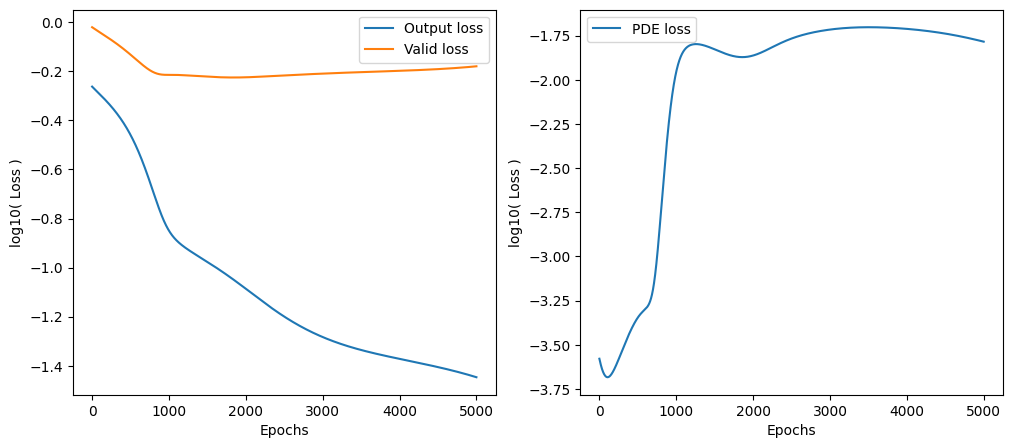

In [31]:



fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=100)

ax[0].plot(np.log10(pinn_result.output_mse_log), label="Output loss")
ax[0].plot(np.log10(pinn_result.valid_mse_log), label="Valid loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("log10( Loss )")
ax[0].legend()


ax[1].plot(np.log10(pinn_result.pde_mse_log), label="PDE loss")
# ax.plot(loss_val_log, label="Val loss")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("log10( Loss )")
ax[1].legend()

plt.savefig("schrodinger_loss.png", dpi=200)

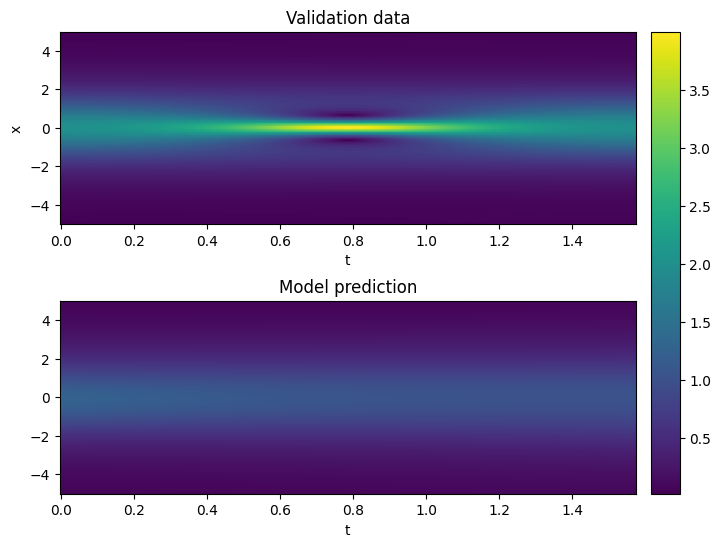

In [32]:
def plot_prediction(model, data_path="data/NLS.mat"):
    model.eval()

    # Load original data
    data = scipy.io.loadmat(data_path)
    x = data["x"].flatten()           # (256,)
    t = data["tt"].flatten()          # (201,)
    X, T = np.meshgrid(x, t, indexing="ij")  # (256, 201)
    h_val = np.sqrt(np.real(data["uu"])**2 + np.imag(data["uu"])**2)

    v_min = np.min(h_val)
    v_max = np.max(h_val)

    XT = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
    XT_tensor = torch.tensor(XT, dtype=torch.float32).to(device)

    with torch.no_grad():
        pred = model(XT_tensor)
        u_pred = pred[:, 0].cpu().numpy().reshape(X.shape)
        v_pred = pred[:, 1].cpu().numpy().reshape(X.shape)
        h_pred = np.sqrt(u_pred**2 + v_pred**2)

    fig = plt.figure(figsize=(8, 6))
    gs = gridspec.GridSpec(2, 2, width_ratios=[20, 1], wspace=0.05, hspace=0.4)

    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[1, 0])
    cax = fig.add_subplot(gs[:, 1])  # Colorbar spanning both plots

    im = ax0.pcolormesh(T, X, h_val, shading='auto', cmap='viridis', vmin=v_min, vmax=v_max)
    ax0.set_xlabel('t')
    ax0.set_ylabel('x')
    ax0.set_title('Validation data')

    ax1.pcolormesh(T, X, h_pred, shading='auto', cmap='viridis', vmin=v_min, vmax=v_max)
    ax1.set_xlabel('t')
    ax0.set_ylabel('x')
    ax1.set_title('Model prediction')

    fig.colorbar(im, cax=cax)

    plt.savefig("schrodinger_h_field.png", dpi=200)

plot_prediction(pinn_result.model)